In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [3]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

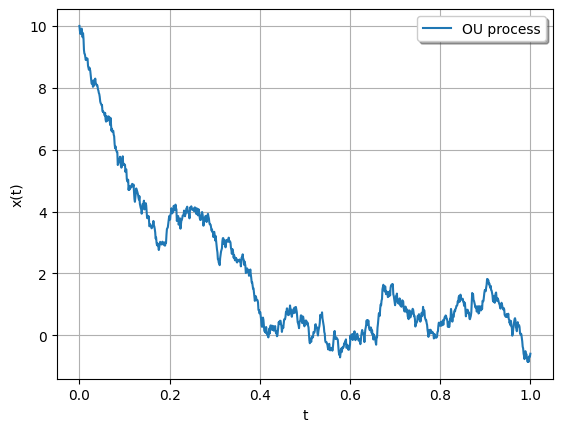

In [4]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

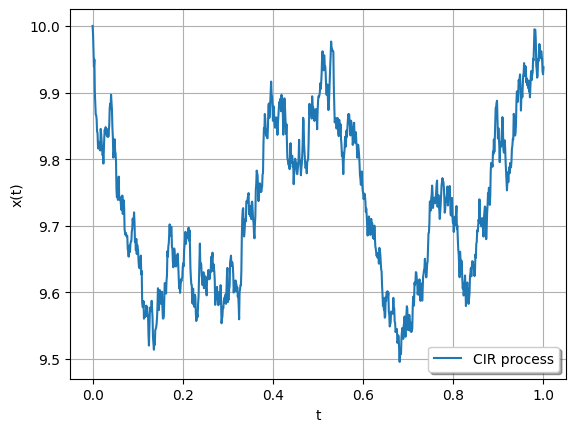

In [5]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

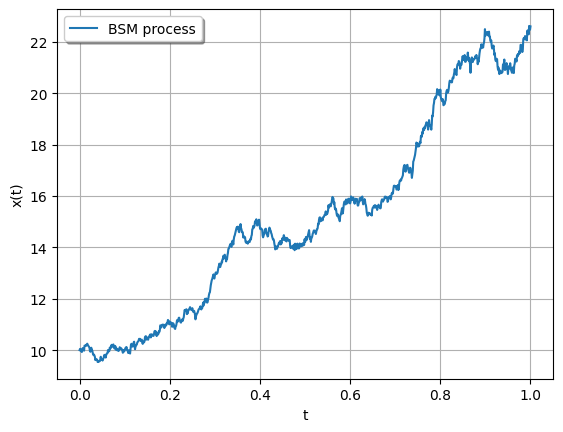

In [6]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [7]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


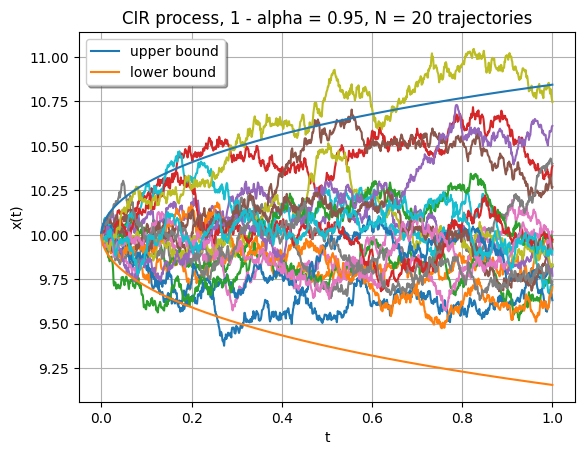

In [8]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


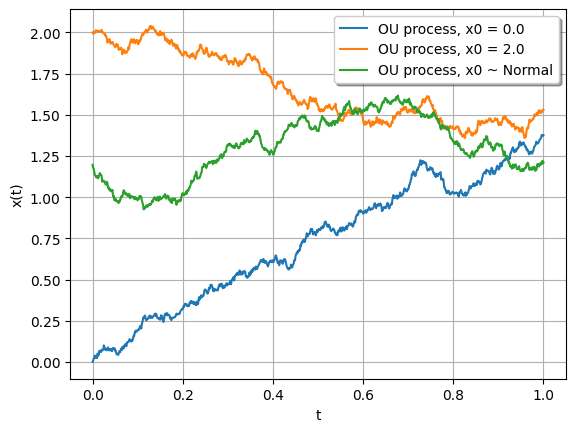

In [9]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 4.1. Define a path with the stationary distribution from the graph and prove mathematically.

For the Ornstein-Uhlenbeck (OU) process defined by the stochastic differential equation (SDE):
$$ dX_t = \theta(\mu - X_t)dt + \sigma dW_t,$$

with parameters $\theta = 1$, $\mu = 1.2$, and $\sigma = 0.3$, the stationary distribution of the process can be derived as follows:

The stationary distribution of an OU process is a Gaussian (normal) distribution defined by:
$$ X_t \sim \mathcal{N}(\mu, \frac{\sigma^2}{2\theta}).$$

Substituting our values:

Mean: $\mu = 1.2$
Variance: $\frac{\sigma^2}{2\theta} = \frac{(0.3)^2}{2 \cdot 1} = \frac{0.09}{2} = 0.045$

Thus, the stationary distribution is:
$$X_t \sim \mathcal{N}(1.2, 0.045).$$
To show that the process converges to the stationary distribution, we can analyze the behavior of the process over time. The solution of the SDE can be expressed as:
$$X_t = e^{-\theta t} X_0 + \mu (1 - e^{-\theta t}) + \sigma \int_0^t e^{-\theta(t-s)} dW_s.$$

As $t \to \infty$:

The term $e^{-\theta t} X_0$ approaches $0$ $(since \theta = 1 > 0)$.
The term $\mu (1 - e^{-\theta t})$ approaches $\mu\$
The stochastic integral converges to a normal distribution due to the Central Limit Theorem.

Thus, as $t$ increases, $X_t$ converges in distribution to $\mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$:
$$\lim_{t \to \infty} X_t \sim \mathcal{N}(1.2, 0.045).$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
theta = 1
mu = 1.2
sigma = 0.3
T = 1
Nx = 1
Nt = 1000

# Generate initial state from stationary distribution
init_state = np.random.normal(mu, np.sqrt(0.045), size=Nx)
params = [theta, mu, sigma]

# Create OU process and solve
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()

# Plot the results
plt.plot(t_data, x_data, label='OU process from stationary distribution')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

### Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts around $1/2$, generate a path and plot it in graph. Prove your solution.




Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $‚áí$ always stay in $[0, 1]$.

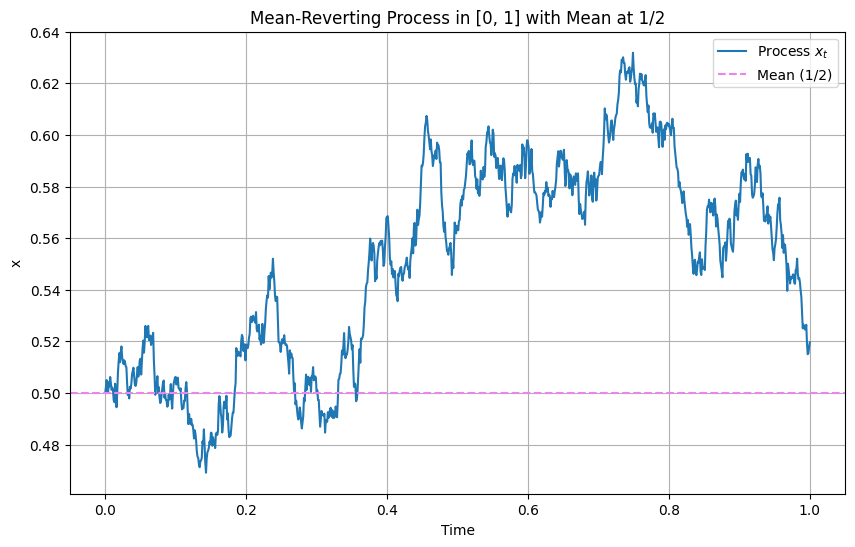

In [11]:
def DesignProcess(theta, sigma, x0, T, N):
    """
    –º–æ–¥–µ–ª–∏—Ä—É–µ—Ç –ø—Ä–æ—Ü–µ—Å—Å —Å –≤–æ–∑–≤—Ä–∞—â–µ–Ω–∏–µ–º –∫ —Å—Ä–µ–¥–Ω–µ–º—É –∏ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏
    
    –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:
    - theta: —Å–∫–æ—Ä–æ—Å—Ç—å –≤–æ–∑–≤—Ä–∞—â–µ–Ω–∏—è –∫ —Å—Ä–µ–¥–Ω–µ–º—É
    - sigma: –ø–∞—Ä–∞–º–µ—Ç—Ä –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏
    - x0: –Ω–∞—á–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å—Å–∞
    - T: –æ–±—â–µ–µ –≤—Ä–µ–º—è –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è
    - N: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —à–∞–≥–æ–≤
    
    –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - time: –º–∞—Å—Å–∏–≤ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —Ç–æ—á–µ–∫
    - x: –º–∞—Å—Å–∏–≤ –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–æ—Ü–µ—Å—Å–∞
    """
    dt = T / N  # —à–∞–≥ –ø–æ –≤—Ä–µ–º–µ–Ω–∏

    # –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–∞—Å—Å–∏–≤–æ–≤ –≤—Ä–µ–º–µ–Ω–∏ –∏ –∑–Ω–∞—á–µ–Ω–∏–π –ø—Ä–æ—Ü–µ—Å—Å–∞
    time = np.linspace(0, T, N + 1)
    x = np.zeros(N + 1)
    x[0] = x0

    for i in range(1, N + 1):
        dw = np.random.normal(0, np.sqrt(dt))  # –ø—Ä–∏—Ä–∞—â–µ–Ω–∏–µ –±—Ä–æ—É–Ω–æ–≤—Å–∫–æ–≥–æ –¥–≤–∏–∂–µ–Ω–∏—è
        # –æ–±–Ω–æ–≤–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–æ—Ü–µ—Å—Å–∞ —Å —É—á–µ—Ç–æ–º –≤–æ–∑–≤—Ä–∞—Ç–∞ –∫ —Å—Ä–µ–¥–Ω–µ–º—É –∏ —Å–ª—É—á–∞–π–Ω–æ–≥–æ –∫–æ–ª–µ–±–∞–Ω–∏—è
        x[i] = x[i - 1] + theta * (0.5 - x[i - 1]) * dt + sigma * x[i - 1] * (1 - x[i - 1]) * dw
        # –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π –≤ –¥–∏–∞–ø–∞–∑–æ–Ω–µ [0, 1]
        x[i] = np.clip(x[i], 0, 1)
    
    return time, x

import numpy as np
import matplotlib.pyplot as plt

# –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–æ—Ü–µ—Å—Å–∞
theta, sigma, x0, T, N = 2, 0.5, 0.5, 1, 1000    

# –≤—ã–∑–æ–≤ —Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ —Ç—Ä–∞–µ–∫—Ç–æ—Ä–∏–∏
time, x = DesignProcess(theta, sigma, x0, T, N)

# –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(10, 6))
plt.plot(time, x, label=r'Process $x_t$')
plt.axhline(0.5, color='violet', linestyle='--', label='Mean (1/2)')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Mean-Reverting Process in [0, 1] with Mean at 1/2')
plt.legend()
plt.grid(True)
plt.show()

### Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:


1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller‚Äôs square root) model;
2.   Radial Ornstein-Uhlenbeck process.


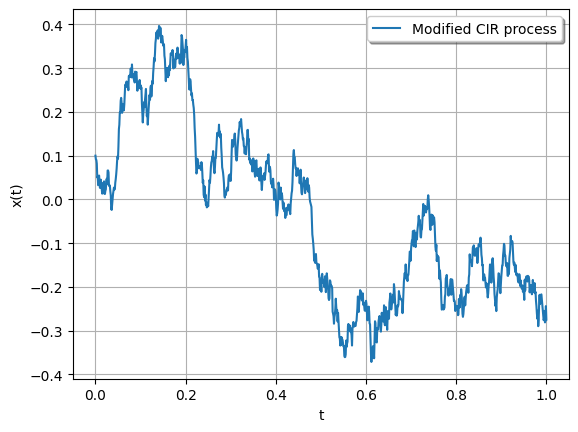

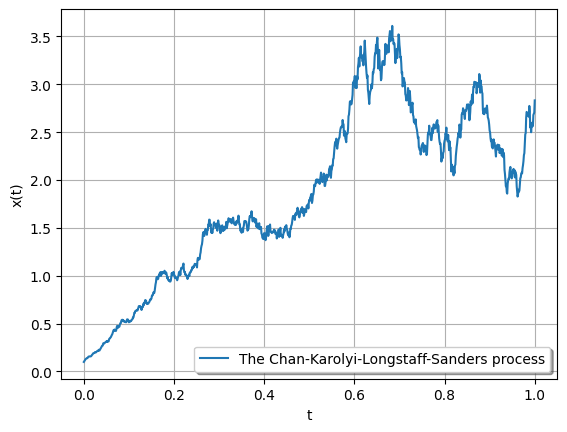

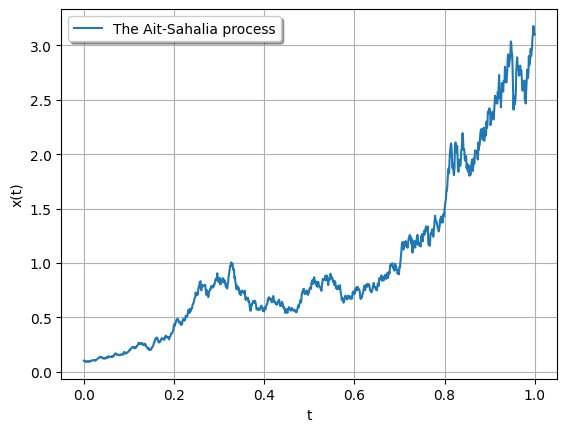

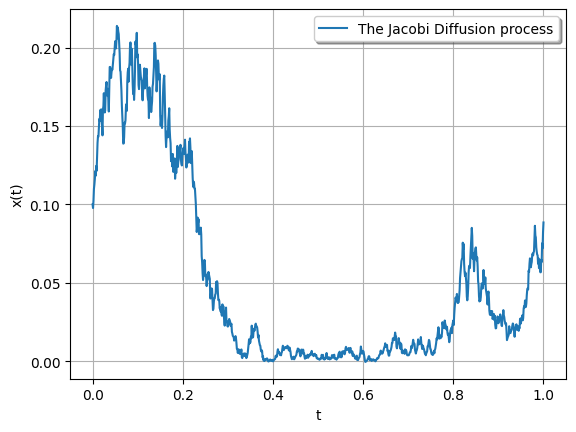

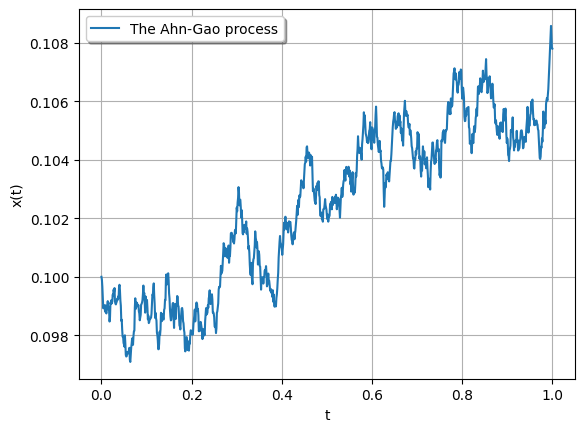

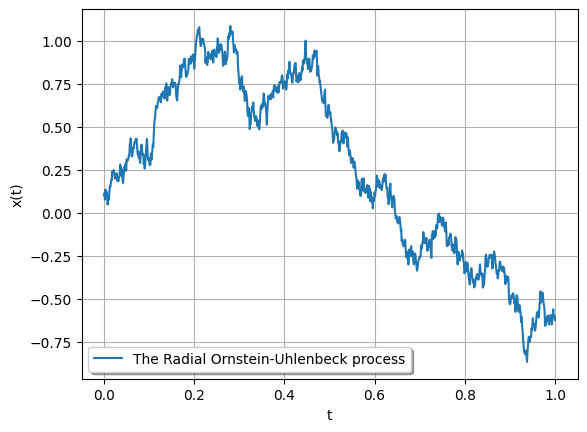

In [30]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state
        self.dt = T / Nt

    def EulerSolution(self):
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nx, self.Nt + 1))
        x_data[:, 0] = self.init_state
        for i in range(1, self.Nt + 1):
            x = x_data[:, i-1]
            drift = self.bxt(x)
            diffusion = self.sigmaxt(x)
            dw = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x_data[:, i] = x + drift * self.dt + diffusion * dw
        return t_data, x_data[0]

def plot_process(process, process_name):
    t_data, x_data = process.EulerSolution()
    plt.plot(t_data, x_data, label=process_name)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.grid(True)
    plt.show()

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å—Å–æ–≤

class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert params[0] + params[1]**2 > 0, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: -self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * np.sqrt(1 + x**2)

class ChanKarolyiLongstaffSandersProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert params[0] > 0 and params[1] > 0 and params[2] > 0 and params[3] > 1/2, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] + self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * x ** self.params[3]

class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: (self.params[0] / x) + self.params[1] + self.params[2] * x + self.params[3] * x**2
        self.sigmaxt = lambda x: self.params[4] * np.maximum(x, 1e-8) ** self.params[5]

class JacobiDiffusionProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert params[0] > 0, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: -self.params[0] * (x - 0.5)
        self.sigmaxt = lambda x: np.sqrt(self.params[0] * np.maximum(x * (1 - x), 1e-8))

class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: x * (self.params[0] - (self.params[2]**3 - self.params[0] * self.params[1]) * x)
        self.sigmaxt = lambda x: self.params[2] * np.maximum(x, 1e-8) ** 1.5

class RadialOrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] * x ** -1 - x
        self.sigmaxt = lambda x: 1  # –ø–æ—Å—Ç–æ—è–Ω–Ω—ã–π –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –¥–∏—Ñ—Ñ—É–∑–∏–∏

# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –∏ –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∫–∞–∂–¥–æ–≥–æ –ø—Ä–æ—Ü–µ—Å—Å–∞

processes = [
    (ModifiedCIRProcess, [2, 0.5], 'Modified CIR process'),
    (ChanKarolyiLongstaffSandersProcess, [4, 0.2, 0.7, 1], 'The Chan-Karolyi-Longstaff-Sanders process'),
    (AitSahaliaProcess, [0.1, 0.3, 1, 0.4, 1, 1], 'The Ait-Sahalia process'),
    (JacobiDiffusionProcess, [0.4], 'The Jacobi Diffusion process'),
    (AhnGaoProcess, [0.1, 0.3, 0.25], 'The Ahn-Gao process'),
    (RadialOrnsteinUhlenbeckProcess, [0.4], 'The Radial Ornstein-Uhlenbeck process')
]

x0 = 0.1
Nx = 1
Nt = 1000
T = 1.0

for process_class, params, name in processes:
    init_state = x0 * np.ones(Nx)
    process = process_class(params, T, Nx, Nt, init_state)
    plot_process(process, name)

---

### Task 6.



Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. ‚Äì 2017. ‚Äì Vol. 5, ‚Ññ 1. ‚Äì P. 34‚Äî37

In [25]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [kappa, theta, sigma]
        self.kappa = params[1]  
        self.theta = params[0]  
        self.sigma = params[2]  

        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def calculate_moments(self, t, X0, n):
        
        init_state = np.full(self.Nx, self.theta) # –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Å–æ—Å—Ç–æ—è–Ω–∏—è –¥–æ –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω–æ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ

        # –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ A(t) –∏ B(t) –¥–ª—è —Ç–æ—á–Ω–æ–≥–æ —Ä–µ—à–µ–Ω–∏—è
        A_t = np.exp(-self.kappa * t) * X0 + self.theta * (1 - np.exp(-self.kappa * t))
        B_t = self.sigma * np.exp(-self.kappa * t)
        
        moment = 0
        
        # –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ —Å—É–º–º—ã –≤ —Ñ–æ—Ä–º—É–ª–µ –î–∂–∞—Ñ–∞—Ä–∏
        for j in range((n // 2) + 1):
            A_term = A_t**(n - 2*j)
            B_term = B_t**(2*j)
            kappa_factor = (1 / (2 * self.kappa)) * (np.exp(2 * self.kappa * t) - 1)
            moment += A_term * B_term * (kappa_factor**(2 * j))
        
        return init_state, moment

    def first_moment(self, t, X0):
        """Compute the first moment E[X(t)]."""
        _, moment = self.calculate_moments(t, X0, 1)
        return moment

    def second_moment(self, t, X0):
        """Compute the second moment E[X^2(t)]."""
        _, moment = self.calculate_moments(t, X0, 2)
        return moment


In [31]:
import numpy as np

class CoxIngersollRossProcess(StochasticProcess): 
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        
        # –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–æ—Ü–µ—Å—Å–∞: —Å–∫–æ—Ä–æ—Å—Ç—å –≤–æ–∑–≤—Ä–∞—â–µ–Ω–∏—è, —Å—Ä–µ–¥–Ω–µ–µ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å
        self.theta = params[0]  
        self.kappa = params[1]  
        self.sigma = params[2]  

        # –¥—Ä–µ–π—Ñ –∏ –¥–∏—Ñ—Ñ—É–∑–∏—è –ø—Ä–æ—Ü–µ—Å—Å–∞ CIR
        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def calculate_moments(self, t, X0, n):
        """–í—ã—á–∏—Å–ª—è–µ—Ç n-–π –º–æ–º–µ–Ω—Ç –¥–ª—è –ø—Ä–æ—Ü–µ—Å—Å–∞ CIR."""
        
        # –Ω–∞—á–∞–ª—å–Ω–æ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ, –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –∫ —Å—Ä–µ–¥–Ω–µ–º—É –ø—Ä–æ—Ü–µ—Å—Å—É
        init_state = np.full(self.Nx, self.theta)
        
        # –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ A(t) –∏ B(t) –¥–ª—è –∞–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–æ–≥–æ —Ä–µ—à–µ–Ω–∏—è
        A_t = np.exp(-self.kappa * t) * X0 + self.theta * (1 - np.exp(-self.kappa * t))
        B_t = self.sigma * np.exp(-self.kappa * t)
        
        moment = 0
        
        # —Å—É–º–º–∞ –ø–æ —Ñ–æ—Ä–º—É–ª–µ –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –º–æ–º–µ–Ω—Ç–∞
        for j in range((n // 2) + 1):
            A_term = A_t**(n - 2 * j)
            B_term = B_t**(2 * j)
            kappa_factor = (1 / (2 * self.kappa)) * (np.exp(2 * self.kappa * t) - 1)
            moment += A_term * B_term * (kappa_factor**(2 * j))
        
        return init_state, moment

    def first_moment(self, t, X0):
        """–í—ã—á–∏—Å–ª—è–µ—Ç –ø–µ—Ä–≤—ã–π –º–æ–º–µ–Ω—Ç E[X(t)]."""
        _, moment = self.calculate_moments(t, X0, 1)
        return moment

    def second_moment(self, t, X0):
        """–í—ã—á–∏—Å–ª—è–µ—Ç –≤—Ç–æ—Ä–æ–π –º–æ–º–µ–Ω—Ç E[X^2(t)]."""
        _, moment = self.calculate_moments(t, X0, 2)
        return moment

# –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–æ—Ü–µ—Å—Å–∞
theta, kappa, sigma = 0.45, 1, 1
params = [theta, kappa, sigma]
t = 1.0
x0 = 0.5
T = 1
Nx = 1  
Nt = 1000
init_state = np.array([x0]) 

# —Å–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ –∏ –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–æ–º–µ–Ω—Ç–æ–≤
cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
first_moment = cir_process.first_moment(t, x0)
second_moment = cir_process.second_moment(t, x0)

print(f'–ü–µ—Ä–≤—ã–π –º–æ–º–µ–Ω—Ç: {first_moment}')
print(f'–í—Ç–æ—Ä–æ–π –º–æ–º–µ–Ω—Ç: {second_moment}')

–ü–µ—Ä–≤—ã–π –º–æ–º–µ–Ω—Ç: 0.46839397205857214
–í—Ç–æ—Ä–æ–π –º–æ–º–µ–Ω—Ç: 1.6004907586026225


### Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by

$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $ùîº(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  ùîº(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.



–ü–æ–ª—É–≤—Ä–µ–º—è: 0.6931
–í—Ä–µ–º–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
–°–∏–º—É–ª–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ (–ø–µ—Ä–≤—ã–µ 5 –∑–Ω–∞—á–µ–Ω–∏–π): [[ 0.          0.          0.          0.          0.        ]
 [ 0.07519108 -0.01290723 -0.03255824  0.02830541 -0.03338675]
 [ 0.04021428 -0.04026477 -0.01782734 -0.00355184  0.04607026]
 [ 0.06876139  0.03365316 -0.0534897  -0.06371842  0.11066305]
 [ 0.03193856  0.13423901 -0.03935144 -0.05437116  0.13302817]]


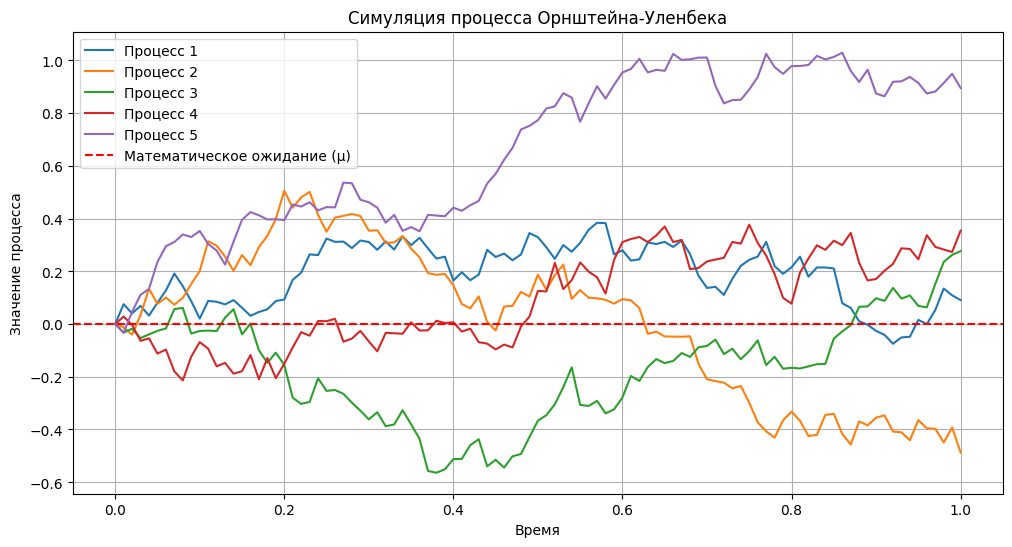

In [36]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è
        x_data[0] = self.init_state
        
        # –°–ª—É—á–∞–π–Ω—ã–µ –≤–µ–ª–∏—á–∏–Ω—ã
        for i in range(1, self.Nt + 1):
            dW = np.random.normal(0, np.sqrt(dt), self.Nx)  # –ë—Ä–æ—É–Ω–æ–≤—Å–∫–æ–µ –¥–≤–∏–∂–µ–Ω–∏–µ
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dW

        return t_data, x_data

class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        
        # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–æ—Ü–µ—Å—Å–∞: [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x) 
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

    def half_life(self):
        """–í—ã—á–∏—Å–ª–µ–Ω–∏–µ –ø–æ–ª—É–≤—Ä–µ–º–µ–Ω–∏"""
        theta = self.params[0]
        return np.log(2) / theta

# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–æ—Ü–µ—Å—Å–∞
theta, mu, sigma = 1.0, 0.0, 0.5  # sigma –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –±–æ–ª—å—à–µ 0
params = [theta, mu, sigma]  
T = 1
Nx = 5  
Nt = 100
init_state = mu * np.ones(Nx)

# –°–æ–∑–¥–∞–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å—Å–∞ –∏ —Ä–∞—Å—á–µ—Ç –ø–æ–ª—É–≤—Ä–µ–º–µ–Ω–∏
ou_process = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
half_life_value = ou_process.half_life()
t_data, simulated_data = ou_process.EulerSolution()

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –Ω–∞–ª–∏—á–∏–µ –Ω–µ–Ω—É–ª–µ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
if np.all(simulated_data == 0):
    print("–í—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è —Å–∏–º—É–ª—è—Ü–∏–∏ —Ä–∞–≤–Ω—ã –Ω—É–ª—é. –ü—Ä–æ–≤–µ—Ä—å—Ç–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã sigma –∏ –≤—Ä–µ–º–µ–Ω–Ω–æ–π —à–∞–≥ dt.")
else:
    print(f"–ü–æ–ª—É–≤—Ä–µ–º—è: {half_life_value:.4f}")
    print("–í—Ä–µ–º–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ:", t_data)
    print("–°–∏–º—É–ª–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ (–ø–µ—Ä–≤—ã–µ 5 –∑–Ω–∞—á–µ–Ω–∏–π):", simulated_data[:5])

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–æ—Ü–µ—Å—Å–∞
plt.figure(figsize=(12, 6))
for i in range(Nx):
    plt.plot(t_data, simulated_data[:, i], label=f'–ü—Ä–æ—Ü–µ—Å—Å {i + 1}')
plt.title('–°–∏–º—É–ª—è—Ü–∏—è –ø—Ä–æ—Ü–µ—Å—Å–∞ –û—Ä–Ω—à—Ç–µ–π–Ω–∞-–£–ª–µ–Ω–±–µ–∫–∞')
plt.xlabel('–í—Ä–µ–º—è')
plt.ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å—Å–∞')
plt.axhline(y=params[1], color='r', linestyle='--', label='–ú–∞—Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –æ–∂–∏–¥–∞–Ω–∏–µ (Œº)')
plt.legend()
plt.grid()
plt.show()